In [130]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0-alpha0'

## Basic TensorFlow usage

In [3]:
a = tf.constant([1, 2])
b = tf.constant([3, 4])
print(a + b)

tf.Tensor([4 6], shape=(2,), dtype=int32)


In [121]:
# convinience function to read EMNIST data into numpy array
def read_mnist(images_path, labels_path):
    with open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28)
        features = features.astype(float)
        flip = features[:,:, ::-1,...]       # note that images are flipped
        features = np.rot90(flip, 1, (1,2))  # and rotated 90deg
        
    return features, labels

## Load Data
Test and training data and labels need to be read from the binary files and converted into a form for easy use. Luckily, this data is small enough to fit in memory.
This data set has some pecularities, like images are flipped and rotated 90%. This needs to be accounts for as well.

In [122]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('data/emnist-bymerge-train-images-idx3-ubyte', 'data/emnist-bymerge-train-labels-idx1-ubyte')
test['features'], test['labels'] = read_mnist('data/emnist-bymerge-test-images-idx3-ubyte', 'data/emnist-bymerge-test-labels-idx1-ubyte')

In [123]:
# Lets read the labels so that directories can be named appropriately
def map_labels(label_mappings="data/emnist-bymerge-mapping.txt"):
    labels_dict = {}
    with open(label_mappings, 'rb') as f:
        # each row of the file has the label first and ascii code next
        for line in f:
            items = line.split()
            # note that data is in bytes, so need to convert
            labels_dict.update({int(items[0]): chr(int(items[1]))})
    return labels_dict

# convenience function to display a grid of random images
def display_images(features, labels, mapping):
    # Now, lets try and generate some sample images to see what the data looks like
    fig=plt.figure(figsize=(9, 9))  # show 8in X 8in image
    columns = 4  # 4 images per row
    rows = 5  # lay out images on 5 rows
    for i in range(1, columns*rows +1):
        img_id = np.random.randint(0, features.shape[0])  # max number of images, from prev section
        fig.add_subplot(rows, columns, i)
        img_data = features[img_id].squeeze()  #,:,:]
        plt.title('Label: %d Char: %s' % ( labels[img_id], mapping[labels[img_id]]))
        plt.imshow(img_data, cmap='gray')
    plt.subplots_adjust(hspace=0.5)
    plt.show()


## Visualize Data
It is always useful to plot a few samples of the data, especially for visual applications, to build intuition and ensure things are as expected.

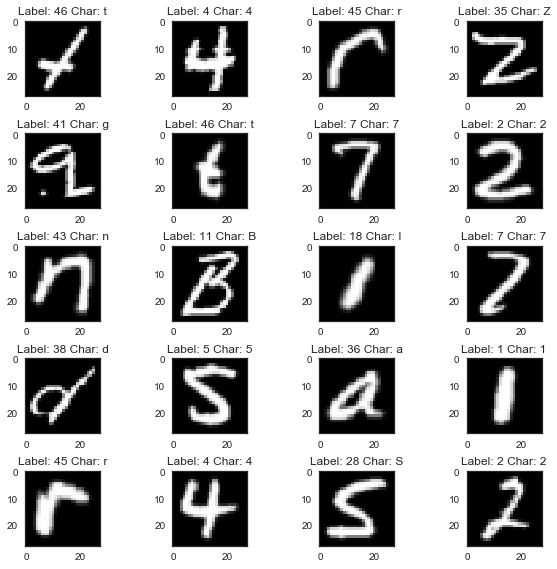

In [124]:
labels = map_labels()
display_images(train['features'], train['labels'], labels)

## Our First Model
Keras makes it really easy to specify model architectures at a high level. In TensorFlow 2.0, further simplfications have been made, so that the code is really clean and simple to follow. In the chapter, the model architecture was specified to have 256 units in first hidden layer, 128 in the second one. The hidden layers had ReLU as the activation function and the output layer had softmax.

In [132]:
model = tf.keras.Sequential()
# flatten from a 28px X 28px into 784 inputs.
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(256, activation='relu'))
# Add another:
model.add(layers.Dense(128, activation='relu'))
# Add a softmax layer with 47 output units:
model.add(layers.Dense(47, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [133]:
one_hot_labels = tf.one_hot(train['labels'], 47)
model.fit(train['features'], one_hot_labels, epochs=5, batch_size=128)

Epoch 1/5
697932/697932 [==============================] - 33s 47us/sample - loss: 1.2860 - accuracy: 0.7156
Epoch 2/5
697932/697932 [==============================] - 29s 42us/sample - loss: 0.5515 - accuracy: 0.8218
Epoch 3/5
697932/697932 [==============================] - 38s 55us/sample - loss: 0.5024 - accuracy: 0.8360
Epoch 4/5
697932/697932 [==============================] - 47s 67us/sample - loss: 0.4843 - accuracy: 0.8422
Epoch 5/5
697932/697932 [==============================] - 38s 54us/sample - loss: 0.4747 - accuracy: 0.8456


In [134]:
model.evaluate(test['features'], tf.one_hot(test['labels'], 47))

116323/116323 [==============================] - 7s 58us/sample - loss: 0.5047 - accuracy: 0.8403


[0.504705616317285, 0.8402637]